In [1]:
!mkdir TRAIN TEST VAL TRAIN/YES TRAIN/NO TEST/YES TEST/NO VAL/YES VAL/NO

In [2]:
import os
import shutil

IMG_PATH = "/content/drive/MyDrive/segmented"

# split the data by train/val/test
ignored = {"pred"}
# split the data by train/val/test
for CLASS in os.listdir(IMG_PATH):
    if CLASS not in ignored:
        if not CLASS.startswith('.'):
            IMG_NUM = len(os.listdir(IMG_PATH +"/"+ CLASS))
            for (n, FILE_NAME) in enumerate(os.listdir(IMG_PATH +"/"+ CLASS)):
                img = IMG_PATH+ '/' +  CLASS + '/' + FILE_NAME
                if n < 300:
                    shutil.copy(img, 'TEST/' + CLASS.upper() + '/' + FILE_NAME)
                elif n < 0.8*IMG_NUM:
                    shutil.copy(img, 'TRAIN/'+ CLASS.upper() + '/' + FILE_NAME)
                else:
                    shutil.copy(img, 'VAL/'+ CLASS.upper() + '/' + FILE_NAME)

In [3]:
import numpy as np 
from tqdm import tqdm, tqdm_notebook
import cv2

def load_data(dir_path, img_size=(100,100)):
    """
    Load resized images as np.arrays to workspace
    """
    X = []
    y = []
    i = 0
    labels = dict()
    for path in tqdm(sorted(os.listdir(dir_path))):
        if not path.startswith('.'):
            labels[i] = path
            for file in os.listdir(dir_path + path):
                if not file.startswith('.'):
                    img = cv2.imread(dir_path + path + '/' + file)
                    X.append(img)
                    y.append(i)
            i += 1
  
    X = np.array(X)
    y = np.array(y)
    print(f'{len(X)} images loaded from {dir_path} directory.')
    return X, y, labels

In [4]:
TRAIN_DIR = 'TRAIN/'
TEST_DIR = 'TEST/'
VAL_DIR = 'VAL/'
IMG_SIZE = (224,224)

In [5]:
X_train, y_train, labels = load_data(TRAIN_DIR, IMG_SIZE)
X_test, y_test, _ = load_data(TEST_DIR, IMG_SIZE)
X_val, y_val, _ = load_data(VAL_DIR, IMG_SIZE)

100%|██████████| 2/2 [00:03<00:00,  1.74s/it]
<ipython-input-3-943c513e4a37>:23: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.array(X)


1800 images loaded from TRAIN/ directory.


100%|██████████| 2/2 [00:01<00:00,  1.89it/s]


600 images loaded from TEST/ directory.


100%|██████████| 2/2 [00:01<00:00,  1.92it/s]

600 images loaded from VAL/ directory.


In [6]:
import imutils

def crop_imgs(set_name, add_pixels_value=0):
    """
    Finds the extreme points on the image and crops the rectangular out of them
    """
    set_new = []
    for img in set_name:
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        gray = cv2.GaussianBlur(gray, (5, 5), 0)

        # threshold the image, then perform a series of erosions +
        # dilations to remove any small regions of noise
        thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
        thresh = cv2.erode(thresh, None, iterations=2)
        thresh = cv2.dilate(thresh, None, iterations=2)

        # find contours in thresholded image, then grab the largest one
        cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        cnts = imutils.grab_contours(cnts)
        c = max(cnts, key=cv2.contourArea)

        # find the extreme points
        extLeft = tuple(c[c[:, :, 0].argmin()][0])
        extRight = tuple(c[c[:, :, 0].argmax()][0])
        extTop = tuple(c[c[:, :, 1].argmin()][0])
        extBot = tuple(c[c[:, :, 1].argmax()][0])

        ADD_PIXELS = add_pixels_value
        new_img = img[extTop[1]-ADD_PIXELS:extBot[1]+ADD_PIXELS, extLeft[0]-ADD_PIXELS:extRight[0]+ADD_PIXELS].copy()
        set_new.append(new_img)

    return np.array(set_new)

In [7]:
X_train_crop = crop_imgs(set_name=X_train)
X_val_crop = crop_imgs(set_name=X_val)
X_test_crop = crop_imgs(set_name=X_test)

<ipython-input-6-75d4db3dd3b1>:33: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(set_new)


In [8]:
def save_new_images(x_set, y_set, folder_name):
    i = 0
    for (img, imclass) in zip(x_set, y_set):
        if imclass == 0:
            cv2.imwrite(folder_name+'NO/'+str(i)+'.jpg', img)
        else:
            cv2.imwrite(folder_name+'YES/'+str(i)+'.jpg', img)
        i += 1

In [9]:
!mkdir TRAIN_CROP TEST_CROP VAL_CROP TRAIN_CROP/YES TRAIN_CROP/NO TEST_CROP/YES TEST_CROP/NO VAL_CROP/YES VAL_CROP/NO

save_new_images(X_train_crop, y_train, folder_name='TRAIN_CROP/')
save_new_images(X_val_crop, y_val, folder_name='VAL_CROP/')
save_new_images(X_test_crop, y_test, folder_name='TEST_CROP/')

In [10]:
from keras.applications.vgg16 import VGG16, preprocess_input

def preprocess_imgs(set_name, img_size):
    set_new = []
    for img in set_name:
        img = cv2.resize(
            img,
            dsize=img_size,
            interpolation=cv2.INTER_CUBIC
        )
        set_new.append(preprocess_input(img))
    return np.array(set_new)

In [11]:
X_train_prep = preprocess_imgs(set_name=X_train_crop, img_size=IMG_SIZE)
X_test_prep = preprocess_imgs(set_name=X_test_crop, img_size=IMG_SIZE)
X_val_prep = preprocess_imgs(set_name=X_val_crop, img_size=IMG_SIZE)

In [12]:
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16, preprocess_input

TRAIN_DIR = 'TRAIN_CROP/'
VAL_DIR = 'VAL_CROP/'
RANDOM_SEED = 42
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)


test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)


train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    color_mode='rgb',
    target_size=IMG_SIZE,
    batch_size=32,
    class_mode='binary',
    seed=RANDOM_SEED
)

validation_generator = test_datagen.flow_from_directory(
    VAL_DIR,
    color_mode='rgb',
    target_size=IMG_SIZE,
    batch_size=16,
    class_mode='binary',
    seed=RANDOM_SEED
)

Found 1800 images belonging to 2 classes.
Found 600 images belonging to 2 classes.


In [13]:
from tensorflow import keras
from keras import layers
from keras import Sequential

model = Sequential([
    
    keras.layers.Conv2D(16,(3,3),padding='same',activation="relu",input_shape =X_train_prep[0].shape),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPooling2D(pool_size=(2,2),strides=2,padding = 'same'),

    keras.layers.Conv2D(32,(3,3),padding='same',activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPooling2D(pool_size=(2,2),strides=2,padding = 'same'),

    keras.layers.Conv2D(64,(3,3),padding='same',activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPooling2D(pool_size=(2,2),strides=2,padding = 'same'),

    keras.layers.Conv2D(128,(3,3),padding='same',activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPooling2D(pool_size=(2,2),strides=2,padding = 'same'),

    keras.layers.Conv2D(256,(3,3),padding='same',activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPooling2D(pool_size=(2,2),strides=2,padding = 'same'),

    keras.layers.Conv2D(512,(3,3),padding='same',activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPooling2D(pool_size=(2,2),strides=2,padding = 'same'),

    keras.layers.Conv2D(128,(3,3),padding='same',activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPooling2D(pool_size=(2,2),strides=2,padding = 'same'),

    keras.layers.Flatten(),
    keras.layers.Dense(16,activation="relu"),
    keras.layers.Dense(1,activation="sigmoid")

])

In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 16)      448       
                                                                 
 batch_normalization (BatchN  (None, 224, 224, 16)     64        
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 32)      4640      
                                                                 
 batch_normalization_1 (Batc  (None, 112, 112, 32)     128       
 hNormalization)                                                 
                                                        

In [15]:
model.compile(optimizer='adam',loss='binary_crossentropy', metrics=['accuracy'])

In [16]:
history = model.fit(
                    train_generator,
                    steps_per_epoch=50,
                    epochs=15,
                    validation_data=validation_generator,
                    validation_steps=25
                   )

Epoch 1/15
50/50 [==============================] - 18s 160ms/step - loss: 0.6123 - accuracy: 0.7392 - val_loss: 0.9564 - val_accuracy: 0.5250
Epoch 2/15
50/50 [==============================] - 8s 160ms/step - loss: 0.3178 - accuracy: 0.8572 - val_loss: 0.7746 - val_accuracy: 0.6125
Epoch 3/15
50/50 [==============================] - 7s 148ms/step - loss: 0.2525 - accuracy: 0.9038 - val_loss: 0.6923 - val_accuracy: 0.7325
Epoch 4/15
50/50 [==============================] - 7s 145ms/step - loss: 0.2477 - accuracy: 0.8864 - val_loss: 0.4831 - val_accuracy: 0.7450
Epoch 5/15
50/50 [==============================] - 7s 144ms/step - loss: 0.1591 - accuracy: 0.9365 - val_loss: 0.3091 - val_accuracy: 0.8975
Epoch 6/15
50/50 [==============================] - 7s 147ms/step - loss: 0.0944 - accuracy: 0.9657 - val_loss: 0.2032 - val_accuracy: 0.9200
Epoch 7/15
50/50 [==============================] - 7s 146ms/step - loss: 0.0818 - accuracy: 0.9669 - val_loss: 0.1306 - val_accuracy: 0.9550
Epoch

In [17]:
model.evaluate(validation_generator,verbose=1)

38/38 [==============================] - 2s 62ms/step - loss: 0.2534 - accuracy: 0.9250


[0.2533940374851227, 0.925000011920929]

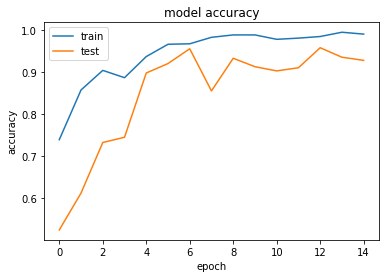

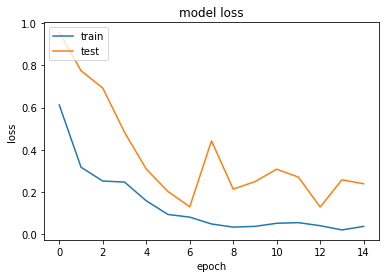

In [18]:
from matplotlib import pyplot as plt

# summarize Model for Accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

print("\n")

# summarize Model for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [19]:
import itertools
from matplotlib import pyplot as plt

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize = (6,6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    cm = np.round(cm,2)
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

19/19 [==============================] - 0s 16ms/step
Train Accuracy = 0.98
Val Accuracy = 0.92
Test Accuracy = 0.83


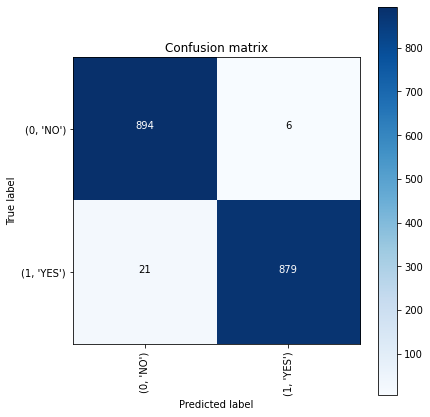

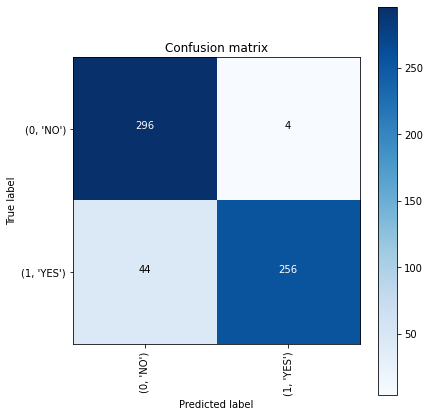

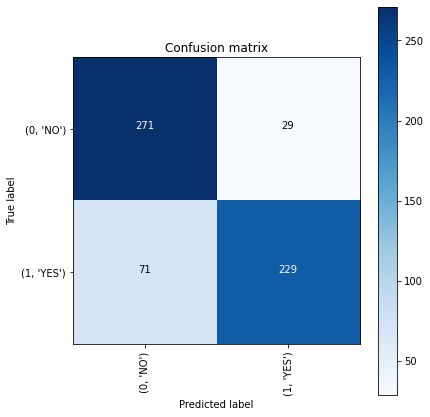

In [20]:
import tensorflow
from sklearn.metrics import confusion_matrix,accuracy_score

train_predictions = model.predict(X_train_prep)
val_predictions = model.predict(X_val_prep)
test_predictions = model.predict(X_test_prep)

#Binarizing all the outputs by setting the threshold to 0.5

train_predictions = [1 if x>0.5 else 0 for x in train_predictions]
val_predictions = [1 if x>0.5 else 0 for x in val_predictions]
test_predictions = [1 if x>0.5 else 0 for x in test_predictions]

#Calculating the accuracy scores

train_accuracy = accuracy_score(y_train, train_predictions)
val_accuracy = accuracy_score(y_val, val_predictions)
test_accuracy = accuracy_score(y_test, test_predictions)
print('Train Accuracy = %.2f' % train_accuracy)
print('Val Accuracy = %.2f' % val_accuracy)
print('Test Accuracy = %.2f' % test_accuracy)

#Plotting the confusion matrix on the test data

confusion_mtx = confusion_matrix(y_train, train_predictions) 
cm = plot_confusion_matrix(confusion_mtx, classes = list(labels.items()), normalize=False)

confusion_mtx = confusion_matrix(y_val, val_predictions) 
cm = plot_confusion_matrix(confusion_mtx, classes = list(labels.items()), normalize=False)

confusion_mtx = confusion_matrix(y_test, test_predictions) 
cm = plot_confusion_matrix(confusion_mtx, classes = list(labels.items()), normalize=False)

In [21]:
from sklearn import metrics

test_prob_pred = model.predict(X_test_prep)

print('Accuracy score is :', metrics.accuracy_score(y_test, test_predictions))
print('Precision score is :', metrics.precision_score(y_test, test_predictions, average='weighted'))
print('Recall score is :', metrics.recall_score(y_test, test_predictions, average='weighted'))
print('F1 Score is :', metrics.f1_score(y_test, test_predictions, average='weighted'))
print('ROC AUC Score is :', metrics.roc_auc_score(y_test, test_prob_pred,multi_class='ovo', average='weighted'))
print('Cohen Kappa Score:', metrics.cohen_kappa_score(y_test, test_predictions))

print('\t\tClassification Report:\n', metrics.classification_report(y_test, test_predictions))

19/19 [==============================] - 0s 17ms/step
Accuracy score is : 0.8333333333333334
Precision score is : 0.8399972800217598
Recall score is : 0.8333333333333334
F1 Score is : 0.83251264529528
ROC AUC Score is : 0.9309666666666667
Cohen Kappa Score: 0.6666666666666667
		Classification Report:
               precision    recall  f1-score   support

           0       0.79      0.90      0.84       300
           1       0.89      0.76      0.82       300

    accuracy                           0.83       600
   macro avg       0.84      0.83      0.83       600
weighted avg       0.84      0.83      0.83       600



In [22]:
model.save('/content/model.h5')

In [23]:
def plot_samples(X, y, labels_dict, n=50):
    """
    Creates a gridplot for desired number of images (n) from the specified set
    """
    for index in range(len(labels_dict)):
        imgs = X[np.argwhere(y == index)][:n]
        j = 10
        i = int(n/j)

        plt.figure(figsize=(15,6))
        c = 1
        for img in imgs:
            plt.subplot(i,j,c)
            plt.imshow(img[0])

            plt.xticks([])
            plt.yticks([])
            c += 1
        plt.suptitle('Tumor: {}'.format(labels_dict[index]))
        plt.show()

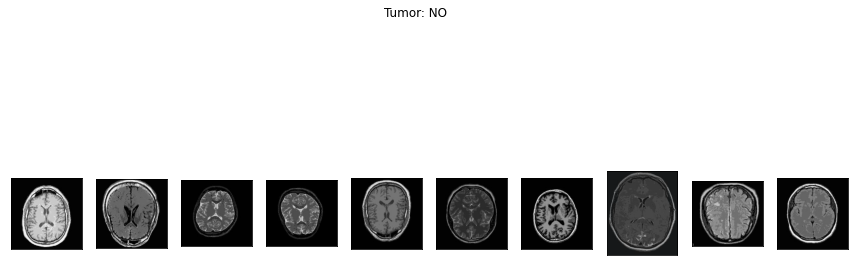

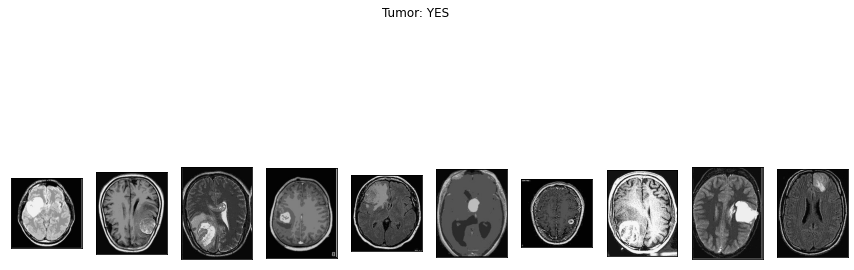

In [24]:
plot_samples(X_train, y_train, labels, 10)

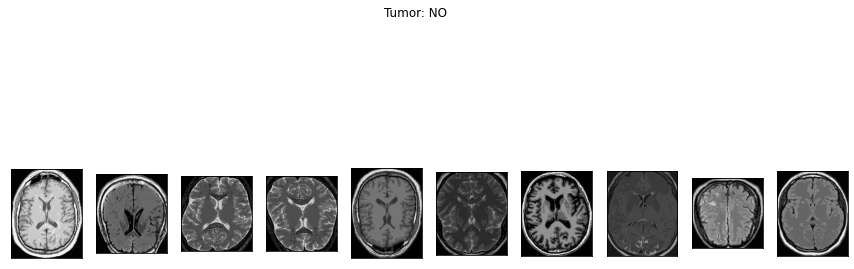

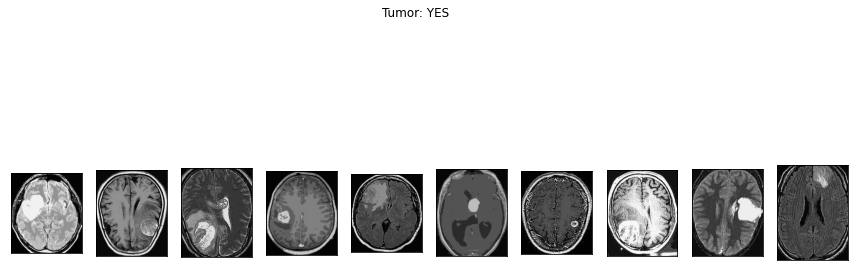

In [25]:
plot_samples(X_train_crop, y_train, labels, 10)

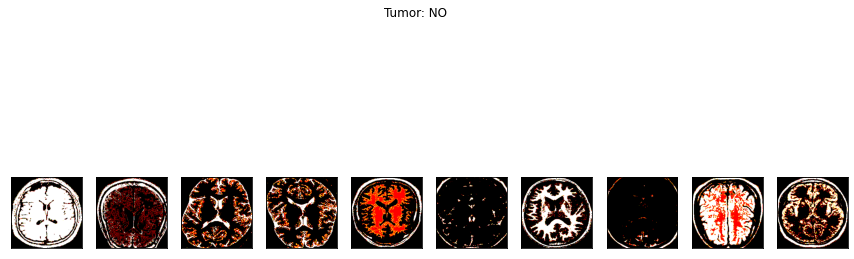

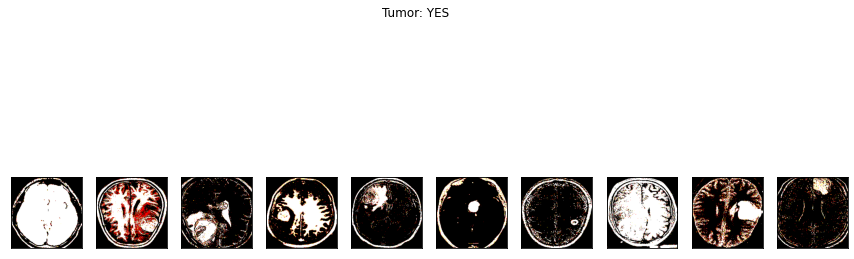

In [26]:
plot_samples(X_train_prep, y_train, labels, 10)